In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Stock_Price_Forecasting/Google')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Stock_Price_Forecasting/Google


# Recurrent Neural Network

In [0]:
!pip uninstall tensorflow

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


## Part 1 - Data Preprocessing

In [6]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Impoting the dataset
dataset = pd.read_csv('getHistoryDownload.csv')
dataset.head(10)

,date,open,high,low,close,volume,changed,changep,adjclose,tradeval,tradevol
0,2014/3/27,568.000,568.00,552.92,558.46,13052,558.46,0.00%,558.46,7.184708e+06,218
1,2014/3/28,561.200,566.43,558.67,559.99,41003,1.53,0.27%,559.99,2.306167e+07,541
2,2014/3/31,566.890,567.00,556.93,556.97,10772,-3.02,-0.54%,556.97,6.039945e+06,184
3,2014/4/1,558.710,568.45,558.71,567.16,7932,10.19,1.83%,567.16,4.486382e+06,132
4,2014/4/2,565.106,604.83,562.19,567.00,146697,-0.16,-0.03%,567.00,8.330760e+07,1381
5,2014/4/3,569.850,587.28,564.13,569.74,5087530,2.74,0.48%,569.74,2.927504e+09,66843
6,2014/4/4,574.650,577.77,543.00,543.14,6377658,-26.60,-4.67%,543.14,3.530804e+09,82897
7,2014/4/7,540.740,548.48,527.15,538.15,4389569,-4.99,-0.92%,538.15,2.359743e+09,59428
8,2014/4/8,542.600,555.00,541.61,554.90,3152406,16.75,3.11%,554.90,1.737145e+09,44962
9,2014/4/9,559.620,565.37,552.95,564.14,3324742,9.24,1.67%,564.14,1.859192e+09,42875


In [7]:
# Select a point to split the training set and test set
# EX: After 2019/7/30 for test set.
index = -1
for i in range(len(dataset['date'])):
    if dataset['date'][i] == '2019/10/1':
        index = i
        break
if index < 0:
    print('Data does not exist!')
else:
    print('index = ', index)
    dataset_train = dataset[0: index]
    dataset_test = dataset[index: ]

index =  1388


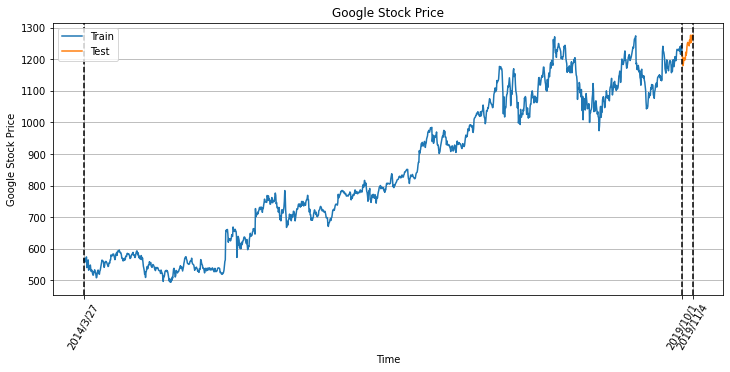

In [11]:
# Plot Google Stock Price
plt.figure(figsize = (12, 5))
plt.plot(range(index), dataset['open'][0:index], label = 'Train')
plt.plot(range(index, len(dataset)), dataset['open'][index:len(dataset)], label = 'Test')
c = [0, index, len(dataset) - 1]
plt.xticks(c, dataset['date'][c], rotation = 60)
plt.axvline(0, color = 'black', ls = '--')
plt.axvline(index, color = 'black', ls = '--')
plt.axvline(len(dataset) - 1, color = 'black', ls = '--')
plt.title('Google Stock Price')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [12]:
# Impoting the training set
training_set = dataset_train.iloc[:, 1:2].values

# Feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
L_train = len(training_set_scaled) # L = 1388
timesteps = 60
X_train = []
y_train = []
for i in range(timesteps, L_train):
    X_train.append(training_set_scaled[i - timesteps: i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
'''
Data 重新塑形到 Keras 所需要的形狀 [samples, time_steps, features]：[1328 * 60 * 1]，
意思是我有 1328 個樣本點，每個樣本點有 60 個時間步長和 1 個特徵。
'''

'\nData 重新塑形到 Keras 所需要的形狀 [samples, time_steps, features]：[1328 * 60 * 1]，\n意思是我有 1328 個樣本點，每個樣本點有 60 個時間步長和 1 個特徵。\n'

In [0]:
# Impoting the test set
real_stock_price = dataset_test.iloc[:, 1:2].values
y_test = sc.transform(real_stock_price)

# Getting the predicted stock price of 2019
inputs = dataset[len(dataset) - len(dataset_test) - timesteps:]['open'].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

# Creating a data structure with 60 timesteps and 1 output
X_test = []
L_test = len(inputs)
for i in range(timesteps, L_test):
    X_test.append(inputs[i - timesteps:i, 0])
X_test = np.array(X_test)

# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Part 2 - Building the RNN

### Importing the libraries and packages

In [0]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### Building the LSTM

In [0]:
def build_regressor():
    # initializing the LSTM
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(rate = 0.2))

    # Adding the second LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = 64, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))

    # Adding the third LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = 64, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))

    # Adding the forth LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = 64, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))

    # Adding the fifth LSTM layer and some Dropout regularization
    regressor.add(LSTM(units = 64))
    regressor.add(Dropout(rate = 0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return regressor

In [23]:
regressor = build_regressor()
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 60, 64)            16896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 60, 64)            33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 60, 64)            33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 64)           

### Fitting the LSTM to the Training set

In [24]:
tStart = time.time()
h = regressor.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 100, epochs = 300, verbose = 1)
tEnd = time.time()
print('It cost %.2f sec' % (tEnd - tStart))

Train on 1328 samples, validate on 25 samples
Epoch 1/300
1328/1328 [==============================] - 3s 2ms/sample - loss: 0.0907 - val_loss: 0.0668
Epoch 2/300
1328/1328 [==============================] - 0s 252us/sample - loss: 0.0141 - val_loss: 0.0057
Epoch 3/300
1328/1328 [==============================] - 0s 240us/sample - loss: 0.0069 - val_loss: 0.0048
Epoch 4/300
1328/1328 [==============================] - 0s 245us/sample - loss: 0.0061 - val_loss: 0.0016
Epoch 5/300
1328/1328 [==============================] - 0s 234us/sample - loss: 0.0054 - val_loss: 0.0015
Epoch 6/300
1328/1328 [==============================] - 0s 239us/sample - loss: 0.0055 - val_loss: 0.0014
Epoch 7/300
1328/1328 [==============================] - 0s 250us/sample - loss: 0.0051 - val_loss: 0.0067
Epoch 8/300
1328/1328 [==============================] - 0s 238us/sample - loss: 0.0048 - val_loss: 0.0020
Epoch 9/300
1328/1328 [==============================] - 0s 241us/sample - loss: 0.0046 - val_loss: 

### Plotting loss with each epochs

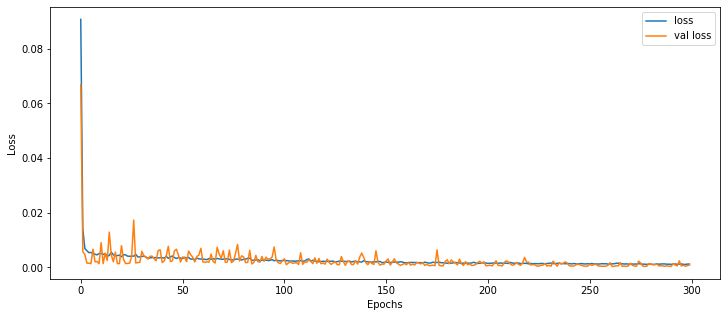

In [31]:
plt.figure(figsize = (12, 5))
plt.plot(h.history['loss'], label = 'loss')
plt.plot(h.history['val_loss'], label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Part 3 - Making the prediction and visualizing the results

### Visualizing the fitting results for training set

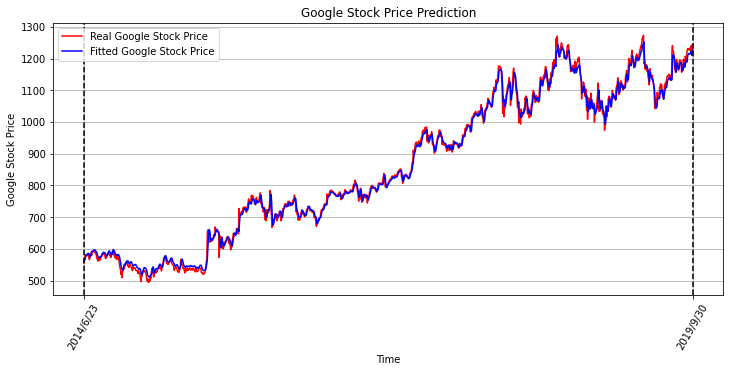

In [40]:
fitted_train_stock_price = regressor.predict(X_train)
fitted_train_stock_price = sc.inverse_transform(fitted_train_stock_price)

plt.figure(figsize = (12, 5))
plt.plot(training_set[timesteps:], color = 'red', label = 'Real Google Stock Price')
plt.plot(fitted_train_stock_price, color = 'blue', label = 'Fitted Google Stock Price')
c = np.array([timesteps, index - 1])
plt.xticks(c - timesteps, dataset['date'][c], rotation = 60)
plt.axvline(c[0] - timesteps, color = 'black', ls = '--')
plt.axvline(c[1] - timesteps, color = 'black', ls = '--')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

### Visualizing the results for test set

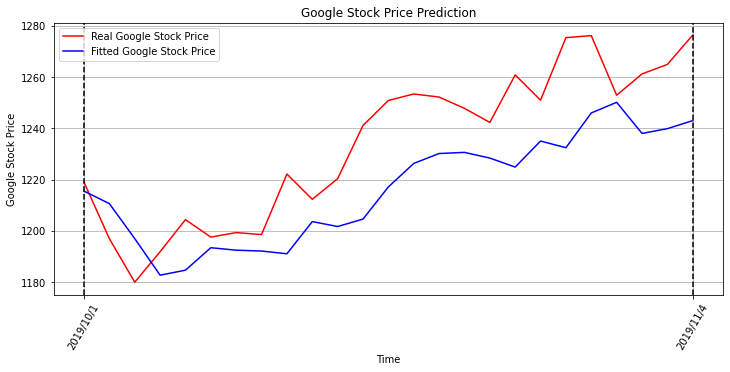

In [39]:
fitted_test_stock_price = regressor.predict(X_test)
fitted_test_stock_price = sc.inverse_transform(fitted_test_stock_price)

plt.figure(figsize = (12, 5))
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(fitted_test_stock_price, color = 'blue', label = 'Fitted Google Stock Price')
c = np.array([index, len(dataset) - 1])
plt.xticks(c - len(dataset_train), dataset_test['date'][c], rotation = 60)
plt.axvline(c[0] - len(dataset_train), color = 'black', ls = '--')
plt.axvline(c[1] - len(dataset_train), color = 'black', ls = '--')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

### Visualizing the results for complete dataset

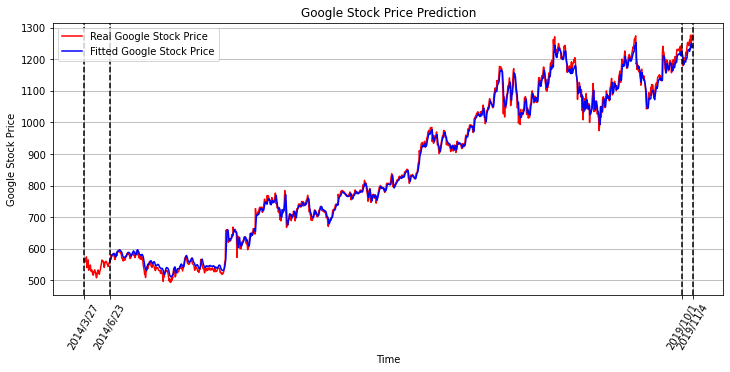

In [38]:
a = np.full((timesteps, 1), np.nan)
fitted_stock_price = np.concatenate((a, 
                                     fitted_train_stock_price, 
                                     fitted_test_stock_price), axis = 0)
plt.figure(figsize = (12, 5))
plt.plot(dataset['open'], color = 'red', label = 'Real Google Stock Price')
plt.plot(fitted_stock_price, color = 'blue', label = 'Fitted Google Stock Price')
c = [0, timesteps, index, len(dataset) - 1]
plt.xticks(c, dataset['date'][c], rotation = 60)
plt.axvline(0, color = 'black', ls = '--')
plt.axvline(timesteps, color = 'black', ls = '--')
plt.axvline(index, color = 'black', ls = '--')
plt.axvline(len(dataset) - 1, color = 'black', ls = '--')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

### Future Prediction

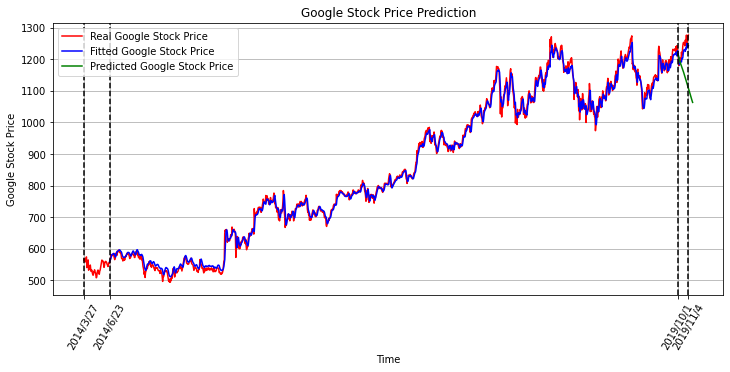

In [37]:
n = len(dataset_test) + 10  # 預測未來幾天的股價
future_stock_price = np.full((n, 1), np.nan)

# x0 = dataset[len(dataset) - timesteps:]['open'].values
x0 = dataset_train[len(dataset_train) - timesteps:]['open'].values
for i in range(n):
    X = x0.reshape(-1, 1)
    X = sc.transform(X)
    X = np.reshape(X, (X.shape[1], X.shape[0], 1)) # 重要!注意 input 格式!
    y = regressor.predict(X)
    future_stock_price[i] = sc.inverse_transform(y)
    x0 = np.append(x0, sc.inverse_transform(y))
    x0 = np.delete(x0, 0, axis = 0)

# a = np.full((len(dataset), 1), np.nan)
a = np.full((len(dataset_train), 1), np.nan)
predicted_future_stock_price = np.concatenate((a, future_stock_price), axis = 0)

plt.figure(figsize = (12, 5))
plt.plot(dataset['open'], color = 'red', label = 'Real Google Stock Price')
plt.plot(fitted_stock_price, color = 'blue', label = 'Fitted Google Stock Price')
plt.plot(predicted_future_stock_price, color = 'green', label = 'Predicted Google Stock Price')
c = [0, timesteps, index, len(dataset) - 1]
plt.xticks(c, dataset['date'][c], rotation = 60)
plt.axvline(0, color = 'black', ls = '--')
plt.axvline(timesteps, color = 'black', ls = '--')
plt.axvline(index, color = 'black', ls = '--')
plt.axvline(len(dataset) - 1, color = 'black', ls = '--')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

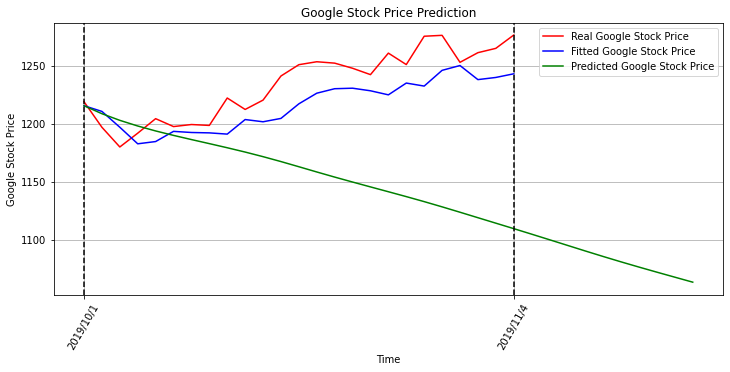

In [36]:
# 預測 testset 區間的股價走向
plt.figure(figsize = (12, 5))
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(fitted_test_stock_price, color = 'blue', label = 'Fitted Google Stock Price')
plt.plot(future_stock_price, color = 'green', label = 'Predicted Google Stock Price')
c = np.array([index, len(dataset) - 1])
plt.xticks(c - len(dataset_train), dataset_test['date'][c], rotation = 60)
plt.axvline(c[0] - len(dataset_train), color = 'black', ls = '--')
plt.axvline(c[1] - len(dataset_train), color = 'black', ls = '--')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend(loc = 'upper left')
plt.legend()
plt.grid()
plt.show()